In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
#chargement des nomenclatures
libelles = pd.read_csv('libelles.csv', sep=';', index_col=['colonne', 'indice'])
#libelles = libelles.set_index(['colonne', 'indice'])

variables = pd.read_csv('variables.csv', sep=';', index_col = ['variable'])


In [3]:
#chargement des données
annees = [str(x) for x in np.arange(2019,2023)]
#fichiers = ['caracteristiques', 'lieux', 'usagers','vehicules']
carac = pd.DataFrame()
lieux = pd.DataFrame()
usagers = pd.DataFrame()
vehicules = pd.DataFrame()
for annee in annees : 
    carac = pd.concat([carac, pd.read_csv(f"../Data/caracteristiques-{annee}.csv", sep=';')])
    lieux = pd.concat([lieux, pd.read_csv(f"../Data/lieux-{annee}.csv", sep=';')])
    usagers = pd.concat([usagers, pd.read_csv(f"../Data/usagers-{annee}.csv", sep=';')])
    vehicules = pd.concat([vehicules, pd.read_csv(f"../Data/vehicules-{annee}.csv", sep=';')])


c:\temp\eric.favre\temp\ipykernel_2448\1100335970.py:10: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  lieux = pd.concat([lieux, pd.read_csv(f"lieux-{annee}.csv", sep=';')])


In [4]:
#correction identifiant accident
carac['Num_Acc'].fillna(carac['Accident_Id'], inplace=True)
carac = carac.drop('Accident_Id', axis = 1)

#jointure carac-lieux
df = pd.merge(left = carac, right = lieux, left_on = 'Num_Acc', right_on='Num_Acc')

#jointure df-vehicules
df = pd.merge(left=df, right=vehicules, left_on='Num_Acc', right_on='Num_Acc')

#jointure df-usagers
df = pd.merge(left=df, right=usagers, right_on='id_vehicule', left_on='id_vehicule')

#suppression des identifiants
df = df.drop(['Num_Acc_x', 'id_vehicule', 'num_veh_x', 'Num_Acc_y','num_veh_y', 'id_usager'], axis = 1)

c:\temp\eric.favre\temp\ipykernel_2448\708482519.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  carac['Num_Acc'].fillna(carac['Accident_Id'], inplace=True)


In [5]:
df = df.replace({
    '-1':np.nan,
    -1:np.nan,
    ' -1':np.nan,
    '#ERREUR':np.nan
})



In [6]:
#secu  : un champ binaire par équipement
for i in range(1,10) :
    df['secu_'+str(i)] = ((df['secu1']==i) | (df['secu2']==i) | (df['secu3']==i))*1

df = df.drop(['secu1','secu2','secu3'], axis = 1)

In [7]:
pd.DataFrame({'column_name': df.columns,'percent_missing': df.isnull().sum() * 100 / len(df)}).sort_values('percent_missing')


,column_name,percent_missing
jour,jour,0.000000
mois,mois,0.000000
an,an,0.000000
hrmn,hrmn,0.000000
dep,dep,0.000000
com,com,0.000000
agg,agg,0.000000
long,long,0.000000
lat,lat,0.000000
catr,catr,0.000000


In [8]:
#elimination des colonnes avec plus de 25% de valeurs manquantes
df.dropna(thresh=len(df)*3/4, axis = 1, inplace= True)

In [9]:
#suppression des lignes sans variable d'Interet
df.dropna(subset=['grav'], inplace = True)

In [10]:
# suppression de l'adresse qui ne sert à rien
df = df.drop('adr', axis = 1)

In [11]:
df.drop(['voie','v1'], axis = 1, inplace=True)

In [12]:
df.dropna(how = 'any', axis=0, inplace=True)

In [13]:
df.isna().sum()

jour       0
mois       0
an         0
hrmn       0
lum        0
dep        0
com        0
agg        0
int        0
atm        0
col        0
lat        0
long       0
catr       0
circ       0
nbv        0
vosp       0
prof       0
pr         0
pr1        0
plan       0
surf       0
infra      0
situ       0
vma        0
senc       0
catv       0
obs        0
obsm       0
choc       0
manv       0
motor      0
place      0
catu       0
grav       0
sexe       0
an_nais    0
trajet     0
secu_1     0
secu_2     0
secu_3     0
secu_4     0
secu_5     0
secu_6     0
secu_7     0
secu_8     0
secu_9     0
dtype: int64

In [14]:
df.shape

(442989, 47)

In [15]:
#conversion des latitudes : longitudes
df['lat']= df['lat'].str.replace(',','.').astype('float')
df['long']= df['long'].str.replace(',','.').astype('float')


In [16]:
#on ajoute un créneau horaire
df['hh'] = df['hrmn'].str[:2]

df.drop('hrmn', axis = 1, inplace= True)

In [17]:
df['hh'] = df['hh'].astype('int')

In [18]:
#on ajoute la date  partir de jour, mois, année
df['date'] = pd.to_datetime(dict(day=df['jour'], month=df['mois'], year=df['an']))

In [19]:
#calcul de l'age des usagers dans l'année de l'accident
df['age'] = df['an'] - df['an_nais'].astype(int)

df.drop('an_nais', axis = 1, inplace = True)

In [20]:
df.drop(['jour','an'], axis = 1, inplace=True)

In [21]:
df.drop(['pr','pr1'], axis = 1, inplace=True)

In [22]:
df.drop(['senc'], axis = 1, inplace=True)

In [23]:
df.drop(['dep','com'], axis = 1, inplace=True)

In [24]:
df.shape

(442989, 41)

In [25]:
df.select_dtypes('float').columns

Index(['lum', 'int', 'atm', 'col', 'lat', 'long', 'circ', 'vosp', 'prof',
       'plan', 'surf', 'infra', 'situ', 'vma', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'place', 'grav', 'sexe', 'trajet'],
      dtype='object')

In [42]:
df[['lum', 'int', 'atm', 'col',  'circ', 'vosp', 'prof',
       'plan', 'surf', 'infra', 'situ', 'vma', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'place', 'grav', 'sexe', 'trajet','nbv']] = df[['lum', 'int', 'atm', 'col',  'circ', 'vosp', 'prof',
       'plan', 'surf', 'infra', 'situ', 'vma', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'place', 'grav', 'sexe', 'trajet','nbv']].astype('int')

([<matplotlib.axis.XTick at 0x12844ee57c0>,
 [Text(0.0, 0, 'Indemne'),
  Text(1.0, 0, 'Tué'),
  Text(2.0, 0, 'Blessé hospitalisé'),
  Text(3.0, 0, 'Blessé léger')])

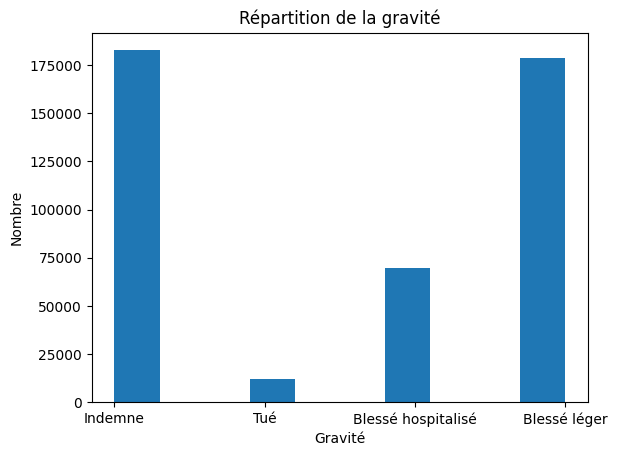

In [27]:
gravite = ['Indemne','Tué','Blessé hospitalisé','Blessé léger']

df['grav'].astype('str').sort_values().hist(grid=False)
plt.title('Répartition de la gravité')
plt.ylabel('Nombre')
plt.xlabel('Gravité')
plt.xticks(ticks=['1','2','3','4'],labels=gravite)

In [28]:
df

,mois,lum,agg,int,atm,col,lat,long,catr,circ,...,secu_3,secu_4,secu_5,secu_6,secu_7,secu_8,secu_9,hh,date,age
0,11,4,1,1,1,2,48.896210,2.470120,1,3,...,0,0,0,0,0,0,0,1,2019-11-30,17
1,11,4,1,1,1,2,48.896210,2.470120,1,3,...,0,0,0,0,0,0,0,1,2019-11-30,26
2,11,4,1,1,1,2,48.896210,2.470120,1,3,...,0,0,0,0,0,0,0,1,2019-11-30,60
3,11,3,1,1,1,6,48.930700,2.368800,1,1,...,0,0,0,0,0,0,0,2,2019-11-30,25
4,11,1,1,1,1,4,48.935872,2.319174,1,3,...,0,0,0,0,0,0,0,15,2019-11-28,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494176,1,3,1,1,9,6,46.282532,6.732806,3,2,...,0,0,0,0,0,0,0,4,2022-01-01,27
494177,1,1,1,3,1,3,43.927265,1.915637,3,2,...,0,0,0,0,0,0,0,8,2022-01-01,20
494178,1,1,1,3,1,3,43.927265,1.915637,3,2,...,0,0,0,0,0,0,0,8,2022-01-01,18
494179,1,1,1,3,1,3,43.927265,1.915637,3,2,...,0,0,0,0,0,0,0,8,2022-01-01,69


In [29]:
for v in df.select_dtypes('int').columns :
    cont = pd.crosstab(df[v], df['grav'])
    print(v)
    print(chi2_contingency(cont).pvalue)

mois
3.7209049978151205e-90
lum
0.0
agg
0.0
int
0.0
atm
7.916281360525653e-306
col
0.0
catr
0.0
circ
0.0
vosp
8.151900559932659e-258
prof
0.0
plan
0.0
surf
1.5559956127296118e-174
infra
5.910429278433572e-197
situ
0.0
vma
0.0
catv
0.0
obs
0.0
obsm
0.0
choc
0.0
manv
0.0
motor
0.0
place
0.0
catu
0.0
grav
0.0
sexe
0.0
trajet
0.0
secu_1
0.0
secu_2
0.0
secu_3
1.0802617074062368e-37
secu_4
5.1183778490182064e-83
secu_5
1.1023762926550021e-35
secu_6
0.0
secu_7
4.9762501308549284e-23
secu_8
0.0
secu_9
0.0
hh
0.0
age
0.0


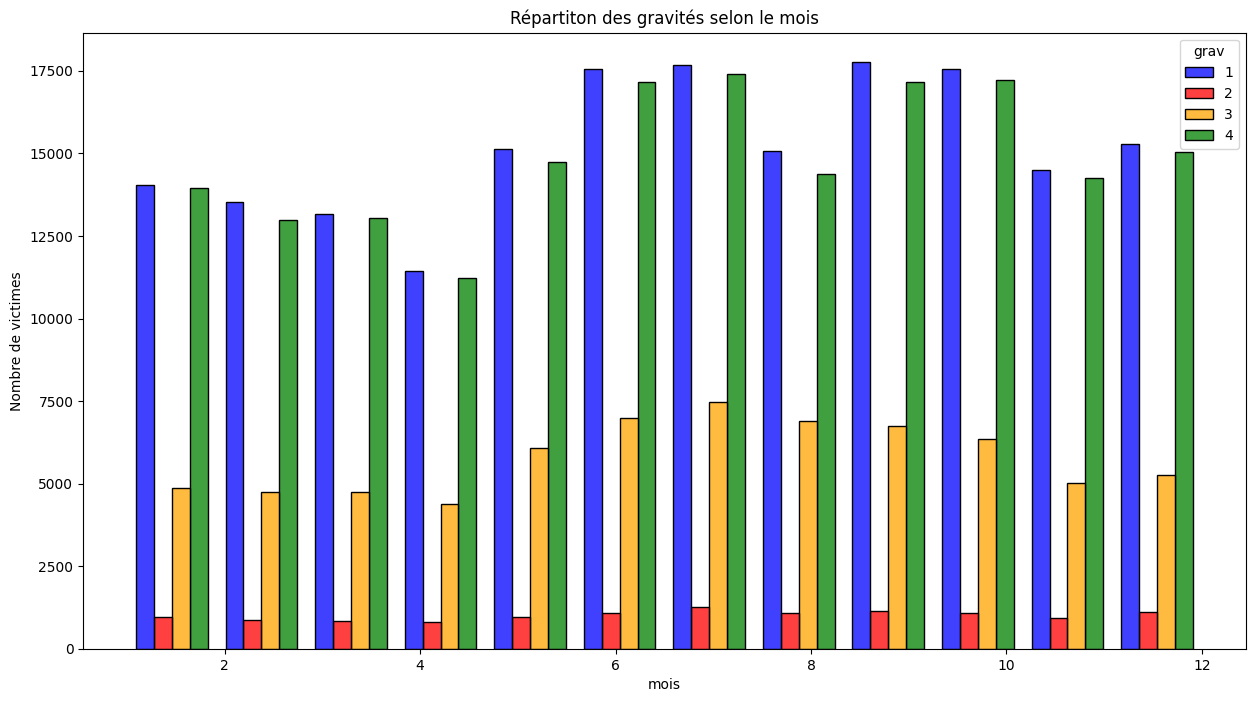

In [30]:
plt.figure(figsize=(15,8))
sns.color_palette("Paired")
palette = ['blue','red','orange','green']
        
sns.histplot(data=df, x='mois',  hue='grav', palette=palette, multiple='dodge', bins = 12, shrink =.8)
plt.ylabel('Nombre de victimes')
plt.title('Répartiton des gravités selon le mois');

In [31]:
chi2_contingency(pd.crosstab(df['mois'], df['grav']))

Chi2ContingencyResult(statistic=np.float64(526.1483402944848), pvalue=np.float64(3.7209049978151205e-90), dof=33, expected_freq=array([[13952.23422478,   926.47409981,  5308.34921183, 13633.94246358],
       [13263.71883726,   880.75442054,  5046.39259214, 12961.13415006],
       [13121.39540485,   871.30367797,  4992.24338076, 12822.05753642],
       [11483.64460291,   762.55165478,  4369.1350643 , 11221.668678  ],
       [15216.64384894,  1010.43504466,  5789.41394482, 14869.50716158],
       [17656.35625264,  1172.43994772,  6717.64129583, 17253.56250381],
       [18077.55110624,  1200.40866703,  6877.89157067, 17665.14865606],
       [15446.83653093,  1025.72059351,  5876.99440844, 15094.44846712],
       [17660.89410121,  1172.74127574,  6719.36779243, 17257.99683062],
       [17419.15053195,  1156.6887101 ,  6627.3926102 , 17021.76814774],
       [14317.32476879,   950.71730901,  5447.25371059, 13990.70421162],
       [15131.2497895 ,  1004.76459912,  5756.92441799, 14786.0611933

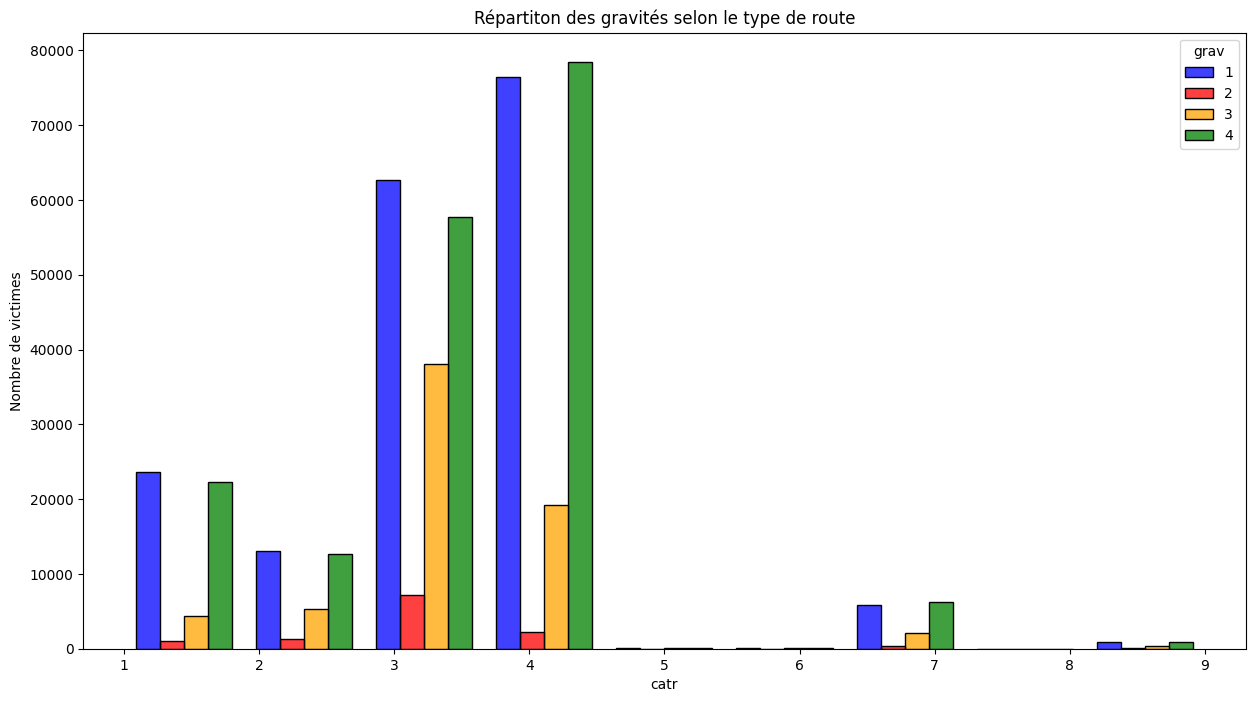

In [32]:
plt.figure(figsize=(15,8))
sns.color_palette("Paired")
palette = ['blue','red','orange','green']
        
#sns.displot(data=df, x='catr', kind='hist', hue='grav', palette=palette, multiple='dodge', bins=9, rwidth=0.7)
sns.histplot(data=df, x='catr',  hue='grav', palette=palette, multiple='dodge', bins=9, shrink=.8)
plt.ylabel('Nombre de victimes')
plt.title('Répartiton des gravités selon le type de route');

In [33]:
chi2_contingency(pd.crosstab(df['catr'], df['grav'])).pvalue

np.float64(0.0)

In [39]:
df.to_csv('./Data/accidents.csv', index = False)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442989 entries, 0 to 494180
Data columns (total 41 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   mois    442989 non-null  int64         
 1   lum     442989 non-null  int64         
 2   agg     442989 non-null  int64         
 3   int     442989 non-null  int64         
 4   atm     442989 non-null  int64         
 5   col     442989 non-null  int64         
 6   lat     442989 non-null  float64       
 7   long    442989 non-null  float64       
 8   catr    442989 non-null  int64         
 9   circ    442989 non-null  int64         
 10  nbv     442989 non-null  int64         
 11  vosp    442989 non-null  int64         
 12  prof    442989 non-null  int64         
 13  plan    442989 non-null  int64         
 14  surf    442989 non-null  int64         
 15  infra   442989 non-null  int64         
 16  situ    442989 non-null  int64         
 17  vma     442989 non-null  int64    